# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. 
Сделать это можно с помощью персонализированных предложений.

Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

In [394]:
from IPython.display import Image

# Как решать

1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Нужно собрать данные по клиентам по следующим группам:
- Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
- Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
- Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
- Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

In [396]:
# диаграмма признаков
Image(url='https://pictures.s3.yandex.net/resources/image_1695485033.png')

# Что делать

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import seaborn as sns

# класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# дополнительные классы для преобразования данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler

# класс для работы с пропусками
from sklearn.impute import SimpleImputer 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# загружаем нужные метрики
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, f1_score

# импортируем модель
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression

import shap
from sklearn.inspection import permutation_importance
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [399]:
pd.__version__

'2.1.4'

In [400]:
np.__version__

'1.26.4'

## Загрузка данных

# market_file.csv

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт». Зависит от наличия определенной подписки у пользователя.
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта за последние 3 месяца.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

# market_money.csv

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период в условных единицах.

# market_time.csv

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

# money.csv

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли в условных единицах.

In [403]:
try:
    market_file = pd.read_csv('market_file.csv')
except:
    market_file = pd.read_csv('/datasets/market_file.csv')

try:
    market_money = pd.read_csv('market_money.csv')
except:
    market_money = pd.read_csv('/datasets/market_money.csv')

try:
    market_time = pd.read_csv('market_time.csv')
except:
    market_time = pd.read_csv('/datasets/market_time.csv')

try:
    money = pd.read_csv('money.csv', sep = ';')
except:
    money = pd.read_csv('/datasets/money.csv', sep = ';')

In [404]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [405]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [406]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [407]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [408]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [409]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [410]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [411]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


## Итоги

1. Во всех трех файлах нет пропусков (null значения)
2. Файлы не требуют приведения типов
3. В файле money разделителем является точка с запятой, а дробная часть написана через запятую

## Предобработка данных

### Проверка на дублирование

In [416]:
market_file.id.value_counts()

id
215348    1
216202    1
216220    1
216219    1
216218    1
216217    1
216216    1
216215    1
216214    1
216213    1
216212    1
216211    1
216210    1
216209    1
216208    1
216207    1
216206    1
216205    1
216204    1
216221    1
216222    1
216223    1
216233    1
216240    1
216239    1
216238    1
216237    1
216236    1
216235    1
216234    1
216232    1
216224    1
216231    1
216230    1
216229    1
216228    1
216227    1
216226    1
216225    1
216203    1
216201    1
216161    1
216200    1
216179    1
216178    1
216177    1
216176    1
216175    1
216174    1
216173    1
216172    1
216171    1
216170    1
216169    1
216168    1
216167    1
216166    1
216165    1
216164    1
216163    1
216180    1
216181    1
216182    1
216192    1
216199    1
216198    1
216197    1
216196    1
216195    1
216194    1
216193    1
216191    1
216183    1
216190    1
216189    1
216188    1
216187    1
216186    1
216185    1
216184    1
216241    1
216242    1
216243    1
2

In [417]:
market_money.id.value_counts()

id
215348    3
216202    3
216220    3
216219    3
216218    3
216217    3
216216    3
216215    3
216214    3
216213    3
216212    3
216211    3
216210    3
216209    3
216208    3
216207    3
216206    3
216205    3
216204    3
216221    3
216222    3
216223    3
216233    3
216240    3
216239    3
216238    3
216237    3
216236    3
216235    3
216234    3
216232    3
216224    3
216231    3
216230    3
216229    3
216228    3
216227    3
216226    3
216225    3
216203    3
216201    3
216161    3
216200    3
216179    3
216178    3
216177    3
216176    3
216175    3
216174    3
216173    3
216172    3
216171    3
216170    3
216169    3
216168    3
216167    3
216166    3
216165    3
216164    3
216163    3
216180    3
216181    3
216182    3
216192    3
216199    3
216198    3
216197    3
216196    3
216195    3
216194    3
216193    3
216191    3
216183    3
216190    3
216189    3
216188    3
216187    3
216186    3
216185    3
216184    3
216241    3
216242    3
216243    3
2

In [418]:
market_money[market_money['id'] == 215348]

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


In [419]:
market_time.id.value_counts()

id
215348    2
216202    2
216220    2
216219    2
216218    2
216217    2
216216    2
216215    2
216214    2
216213    2
216212    2
216211    2
216210    2
216209    2
216208    2
216207    2
216206    2
216205    2
216204    2
216221    2
216222    2
216223    2
216233    2
216240    2
216239    2
216238    2
216237    2
216236    2
216235    2
216234    2
216232    2
216224    2
216231    2
216230    2
216229    2
216228    2
216227    2
216226    2
216225    2
216203    2
216201    2
216161    2
216200    2
216179    2
216178    2
216177    2
216176    2
216175    2
216174    2
216173    2
216172    2
216171    2
216170    2
216169    2
216168    2
216167    2
216166    2
216165    2
216164    2
216163    2
216180    2
216181    2
216182    2
216192    2
216199    2
216198    2
216197    2
216196    2
216195    2
216194    2
216193    2
216191    2
216183    2
216190    2
216189    2
216188    2
216187    2
216186    2
216185    2
216184    2
216241    2
216242    2
216243    2
2

In [420]:
market_time[market_time['id'] == 215348]

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13


In [421]:
money.id.value_counts()

id
215348    1
216202    1
216220    1
216219    1
216218    1
216217    1
216216    1
216215    1
216214    1
216213    1
216212    1
216211    1
216210    1
216209    1
216208    1
216207    1
216206    1
216205    1
216204    1
216221    1
216222    1
216223    1
216233    1
216240    1
216239    1
216238    1
216237    1
216236    1
216235    1
216234    1
216232    1
216224    1
216231    1
216230    1
216229    1
216228    1
216227    1
216226    1
216225    1
216203    1
216201    1
216161    1
216200    1
216179    1
216178    1
216177    1
216176    1
216175    1
216174    1
216173    1
216172    1
216171    1
216170    1
216169    1
216168    1
216167    1
216166    1
216165    1
216164    1
216163    1
216180    1
216181    1
216182    1
216192    1
216199    1
216198    1
216197    1
216196    1
216195    1
216194    1
216193    1
216191    1
216183    1
216190    1
216189    1
216188    1
216187    1
216186    1
216185    1
216184    1
216241    1
216242    1
216243    1
2

### Корректность заполнения - валидация значения

In [423]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [424]:
# по файле market_file будем смотреть только на категориальные признаки, количественные будут анализироваться на этапе анализа

In [425]:
market_file['Покупательская активность'].value_counts()

Покупательская активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

In [426]:
market_file['Тип сервиса'].value_counts()

Тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

In [427]:
# Исправление значения "стандартт"
market_file.loc[market_file['Тип сервиса'] == 'стандартт','Тип сервиса'] = 'стандарт'

In [428]:
market_file['Разрешить сообщать'].value_counts()

Разрешить сообщать
да     962
нет    338
Name: count, dtype: int64

In [429]:
market_file['Популярная_категория'].value_counts()

Популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

In [430]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [431]:
market_money['Период'].value_counts()

Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

In [432]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [433]:
market_time['Период'].value_counts()

Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

In [434]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [435]:
money['Прибыль'] = money['Прибыль'].str.replace(',','.').astype('float')

### Итоги
- Если смотреть по id пользователя, то дублирования строк нет. Таблицы market_money, market_time имеют по 3 и 2 строки на пользователя соответственно, но это связано с разбиением на периоды (столбец "Период")
- В файле "market_file", в столбце "Тип сервисане" все значегния приведены к одному виду (в 10-ти строках было значени "стандартт", вместо "стандрат")
- В файле "money" значения в столбце "Прибыль" были написаны через запятую. Запятая была заменена на точку

## Исследовательский анализ данных

### Поведение покупателя (market_file)

In [439]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [440]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [441]:
cat_columns = market_file.select_dtypes(exclude='number').columns.to_list()
num_columns = market_file.select_dtypes(include='number').columns.to_list()
num_columns.remove('id')

In [442]:
cat_columns

['Покупательская активность',
 'Тип сервиса',
 'Разрешить сообщать',
 'Популярная_категория']

In [443]:
num_columns

['Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит']

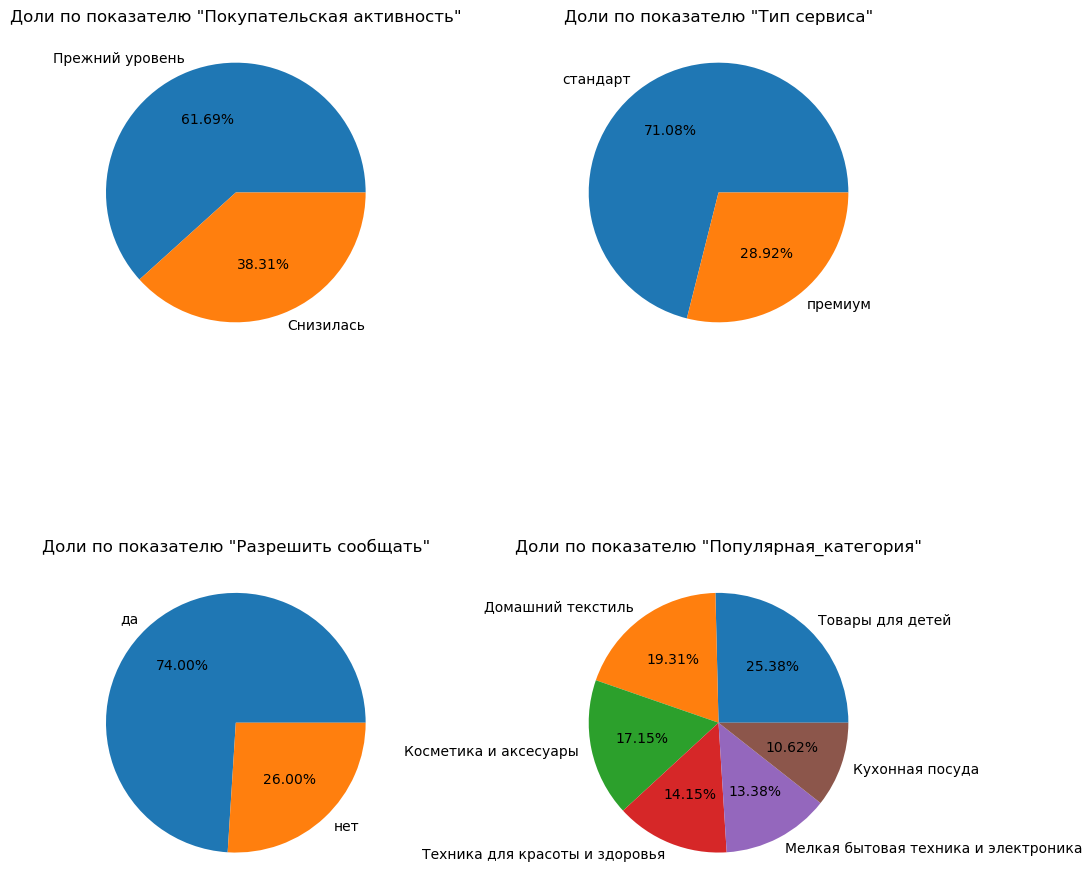

In [444]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,12))
axes = axes.flatten()
for i, col in enumerate(cat_columns):
    # print(col)
    fig_1 = pd.DataFrame(market_file[col].value_counts()).reset_index()
    fig_1.columns = [col,'count']
    axes[i].pie(fig_1['count'], labels=fig_1[col],autopct='%.2f%%')
    axes[i].set_title('Доли по показателю "'+col+'"')
    plt.tight_layout()
    # удилам последний график
    # fig.delaxes(axes[2,1])

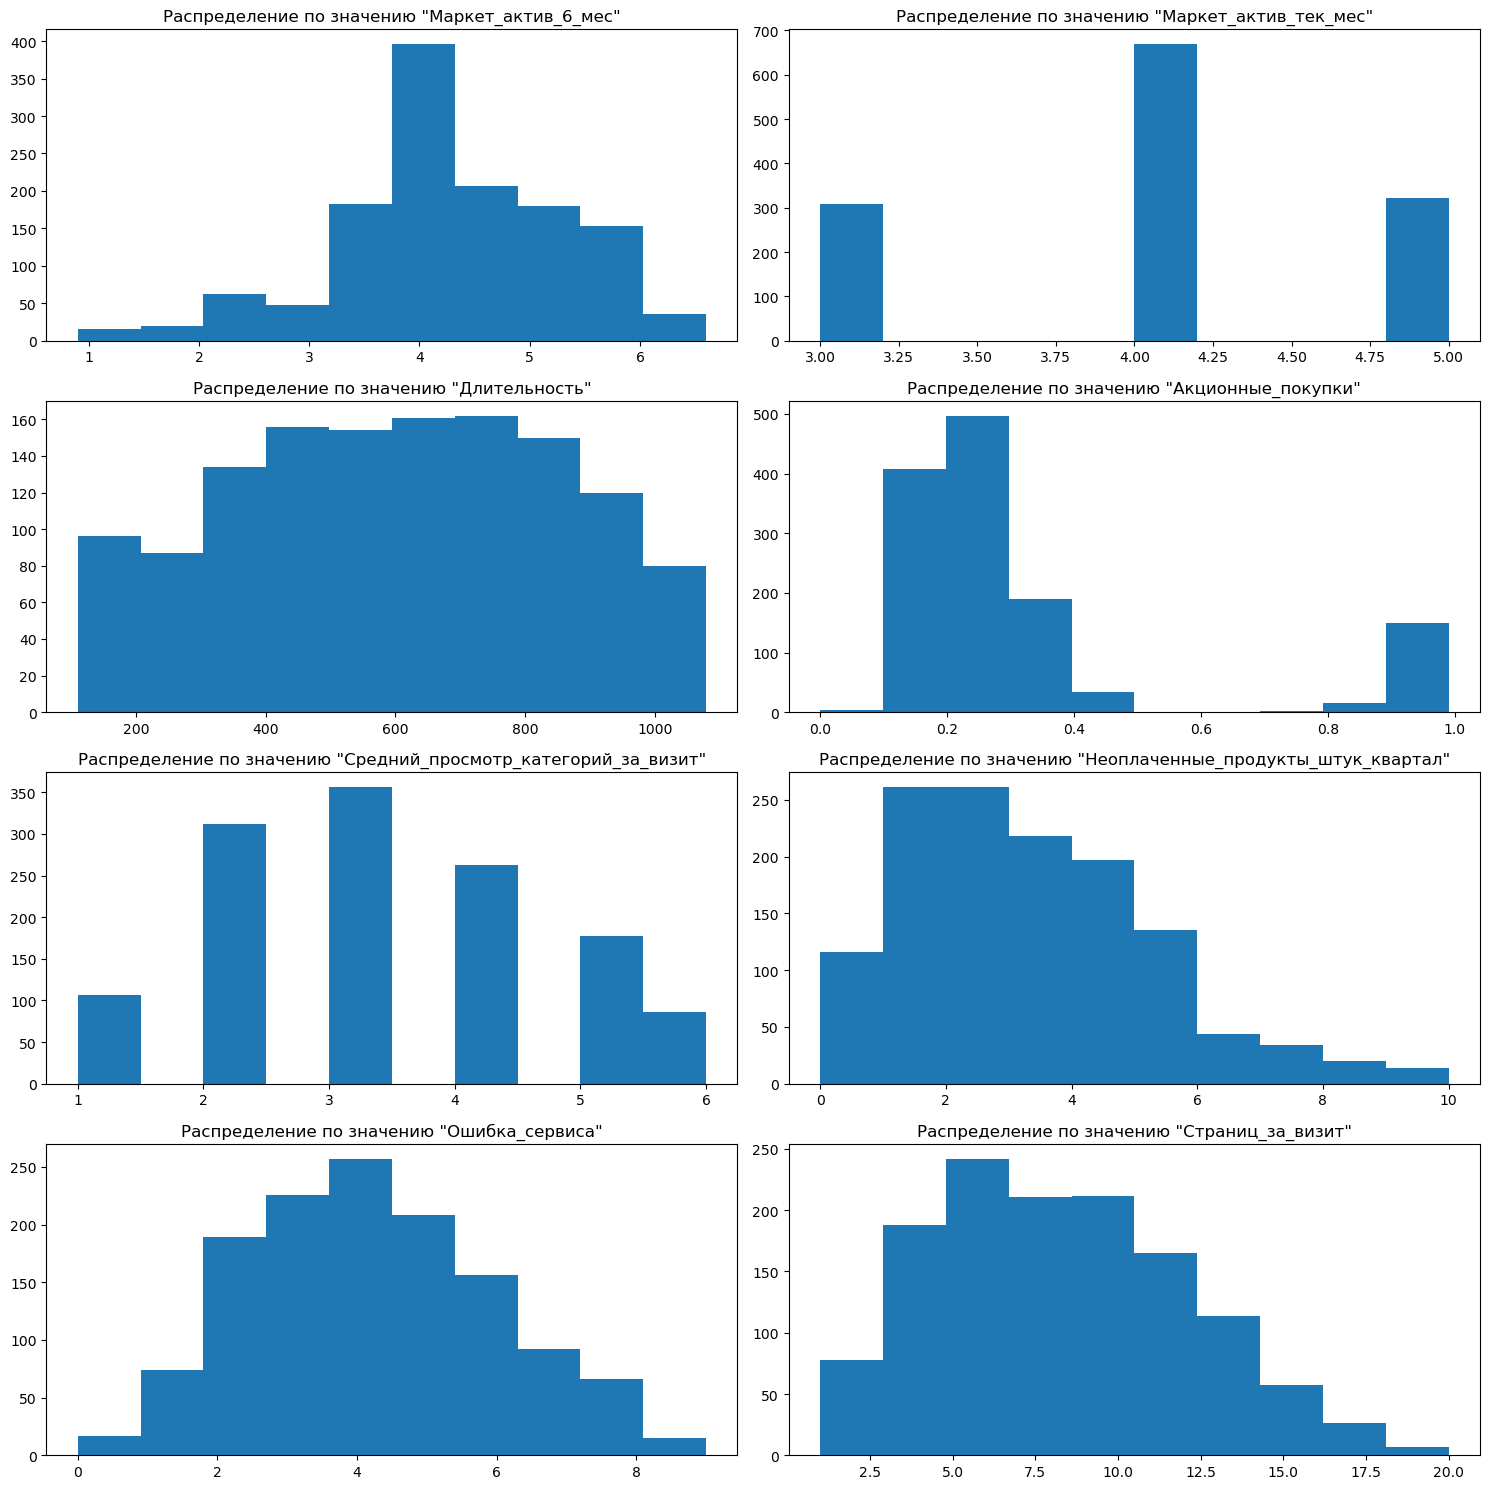

In [445]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,15))
axes = axes.flatten()
for i, col in enumerate(num_columns):
    t = 'Распределение по значению "'+col+'"'
    axes[i].hist(market_file[col])
    axes[i].set_title(t)
    plt.tight_layout()

### Данные о выручке (market_money)

In [447]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


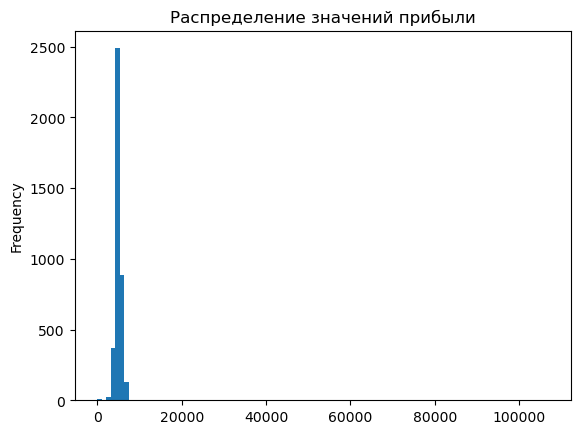

In [448]:
# Просто смотрим как распределены значения в этой талице
market_money['Выручка'].plot.hist(bins = 100,title='Распределение значений прибыли');

In [449]:
market_money['Выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

Стандартное отклонение 1777, а максимальное значение более 10 000

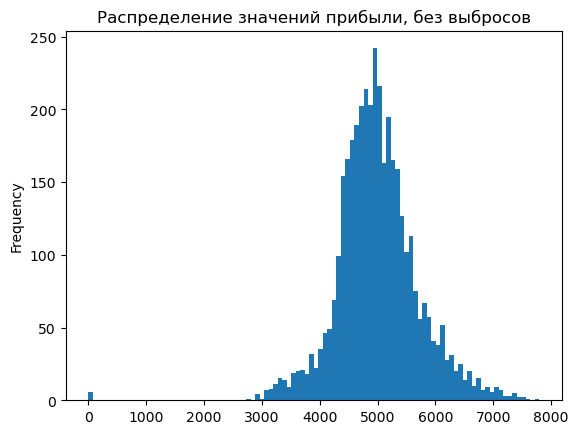

In [451]:
# постром распределение без учет экстремальных значений
market_money[market_money['Выручка'] <= 10000
]['Выручка'].plot.hist(bins = 100,title='Распределение значений прибыли, без выбросов');

In [452]:
market_money = market_money[market_money['Выручка'] <= 10000]

In [453]:
market_money[(market_money['Выручка'] <= 10000) & (market_money['Выручка'] > 0)]['Выручка'].describe()

count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64

In [454]:
# дополнительная таблица, с разбивкой по преодам
# поможет в определении платящих пользователей
market_money_pivot = market_money.pivot(index='id', columns='Период', values='Выручка').reset_index()
market_money_pivot.head()

Период,id,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


In [455]:
# отбор пользователей, активных в каждом из трех периодов
market_money_pivot = market_money_pivot[
(market_money_pivot['предыдущий_месяц'] > 0) &
(market_money_pivot['препредыдущий_месяц'] > 0) &
(market_money_pivot['текущий_месяц'] > 0)
]

### Данные о времени market_time

In [457]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


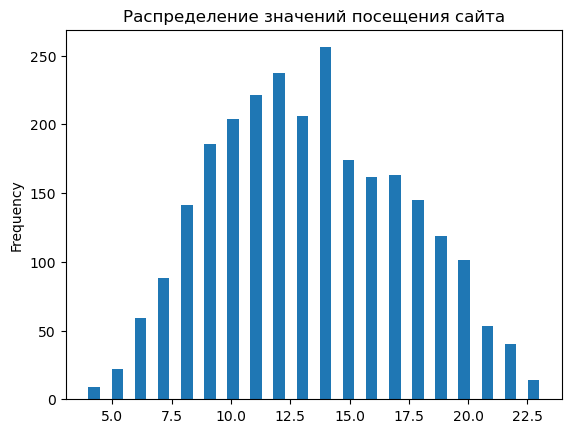

In [458]:
market_time['минут'].plot.hist(bins = 39,title = 'Распределение значений посещения сайта');

In [459]:
# аналогично, market_money, сделаем сводную таблицу
market_time_pivot = market_time.pivot(index='id', columns='Период', values='минут').reset_index()
market_time_pivot.head()

Период,id,предыдцщий_месяц,текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


### Данные о среднемесячной прибыли (money)

In [461]:
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


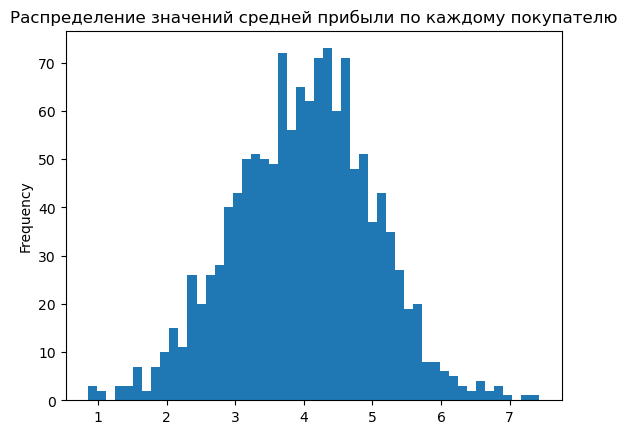

In [462]:
money['Прибыль'].plot.hist(bins = 50,title = 'Распределение значений средней прибыли по каждому покупателю');

### Итоги

1. В данных о поведениях покупателей 'Покупательская активность','Тип сервиса','Разрешить сообщать' являются категориальными — бинарными признаками
   - "Покупательская активность" у 61,7% имеет значение "На прежнем уровне"
   - "Тип сервиса" у 71% иммет значение "Стандарт"
   - 74% пользователей, дали сошласие на рассылку информации о товарах (столбец "Разрешить сообщать")
2. Столбец "Популярные категории" иммет 6 значений. Четверть из них - "Товары для детей"
3. Распределение Маркет_актив_6_мес показывает смещение в правую сторону, то есть пользовате приходит более 4 комуникаций. При этом выделяется цифра 4 - то количество комуникаций больше всех
4. Так же видно, что в текущем месяце (Маркет_актив_тек_мес) в большинстве случаев было 4 комуникации с пользователями
5. "Длительность" (количетсво дней после регистрации) пока что в данных присустсвуют достаточно "старые" пользователи. Основная масси это люди, зарегистрированные от 400 до 800 дней назад
6. Столбец "Акционные покупки" показывает бимодальное распределение - есть пользователи, доля акционных покупок у которых составляет 100%
7. Распределение среднее к-ва категорий за визит является нормальным со среднем 3
8. Общее к-во неоплаченных товаров в корзине в большинстве случаев до 6 - распределение этого показателя смещено влево
9. Аналогичное распределение со смещение влево у к-ва стран посещенных пользователем за последние 3 месяца - много страниц (больше 8-ми - среднее значение) посещают не так много пользователей. В основном к-во просмотренных страниц от трех до 10
10. К-во збоев, которое затронуло покупателя так же распределено нормально
11. В данных о выручке были выявлены большие значения (более 10000). Убрав такие значения и значения 0 получили нормлаьно распределение со среднем 5000
12. Значения времени проведенного на сайте и значения прибыли продавцов похожи на распределены нормально

## Объединение таблиц

In [466]:
# Для каждого файла заменим столбец с индексами на столбце с id
market_file = market_file.set_index('id')
# использую ранее созданную плоскую таблицу с затратами пользователей по периодам
market_money_pivot = market_money_pivot.set_index('id')
market_time_pivot = market_time_pivot.set_index('id')

In [467]:
market_money_pivot.rename(columns={"предыдущий_месяц": "выручка_предыдущий_месяц", 
                                   "препредыдущий_месяц": "выручка_препредыдущий_месяц", 
                                   "текущий_месяц": "выручка_текущий_месяц"},inplace = True)

market_time_pivot.rename(columns={"предыдцщий_месяц": "минуты_предыдцщий_месяц", 
                                   "текущий_месяц": "минуты_текущий_месяц"},inplace = True)

In [468]:
pre_df = pd.merge(market_file,market_money_pivot,how = 'inner',left_index=True, right_index=True)
result_df = pd.merge(pre_df,market_time_pivot,how = 'inner',left_index=True, right_index=True)

In [469]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1296 non-null   object 
 1   Тип сервиса                          1296 non-null   object 
 2   Разрешить сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит            

### Итоги

1. После объединения в данных осталось 1297 уникальных пользователей
2. Были переименованы столбцы с файлах с временем и выручкой, так как в этих вайлах названия периодов были одинаковые

## Корреляционный анализ

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минуты_предыдцщий_месяц', 'минуты_текущий_месяц']


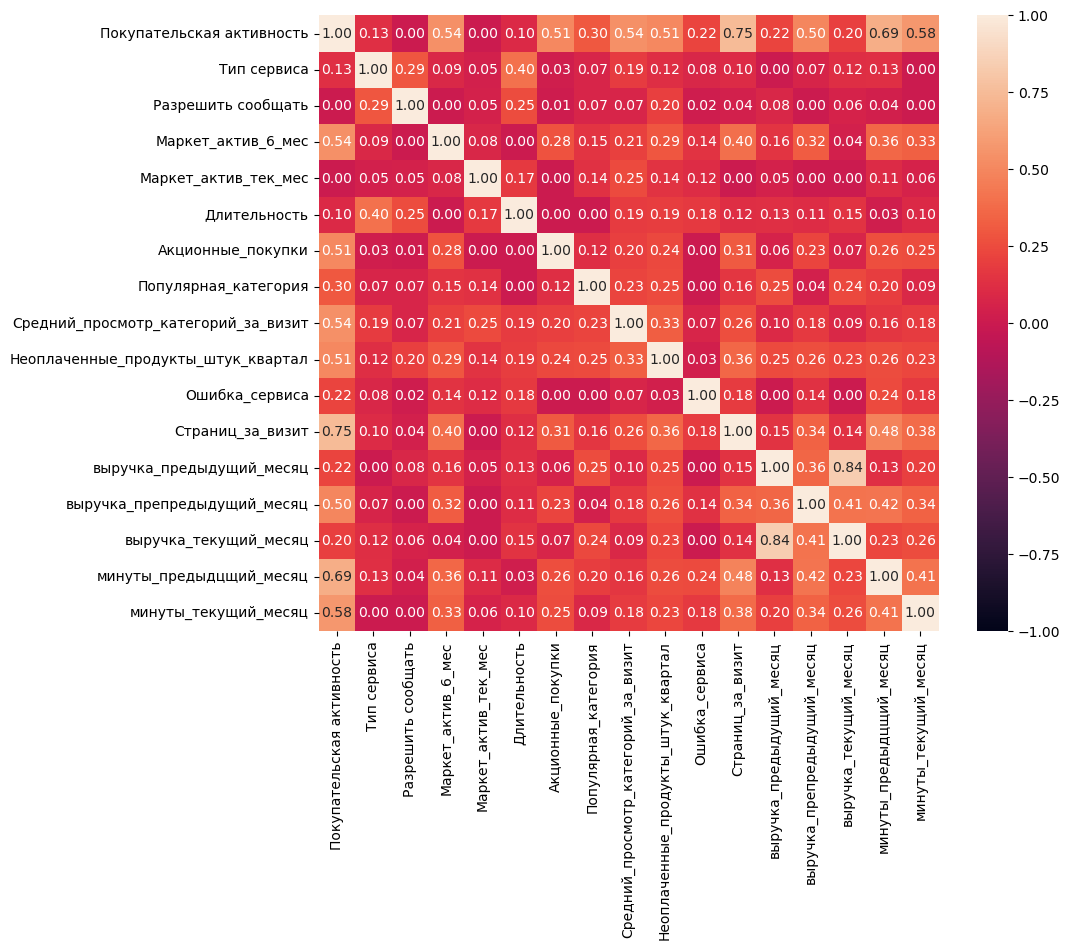

In [473]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(result_df[result_df.columns[0:]].phik_matrix() , 
            vmin=-1, 
            vmax=1, 
            annot=True, 
            fmt=".2f",
            ax = ax);

### Итоги

Матрица корреляций показывает связь целевого признака "Покупательская активность" с количеством минут в текущем и предыдущем месыце (0,58 и 0,69 соответственно), и с показателем количества посещенных страниц за визит (0,75), но такой показатель кореляции не говорит о сильной линейно зависимости между этими переменными

## Использование пайплайнов

1. Так как решается задача бинарной классификации, качество можели будет определяться с помощью метрики Accuracy 

In [478]:
result_df.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдцщий_месяц,минуты_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [479]:
cat_columns = result_df.select_dtypes(exclude='number').columns.to_list()
cat_columns.remove('Покупательская активность')
num_columns = result_df.select_dtypes(include='number').columns.to_list()

In [480]:
cat_columns

['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

In [481]:
num_columns

['Маркет_актив_6_мес',
 'Маркет_актив_тек_мес',
 'Длительность',
 'Акционные_покупки',
 'Средний_просмотр_категорий_за_визит',
 'Неоплаченные_продукты_штук_квартал',
 'Ошибка_сервиса',
 'Страниц_за_визит',
 'выручка_предыдущий_месяц',
 'выручка_препредыдущий_месяц',
 'выручка_текущий_месяц',
 'минуты_предыдцщий_месяц',
 'минуты_текущий_месяц']

In [482]:
X = result_df.drop(columns=['Покупательская активность'])
y = result_df['Покупательская активность']

In [483]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [484]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    # test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = result_df['Покупательская активность']
)

In [551]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(drop='first'), cat_columns)  # по умолчанию
    ],
    remainder='passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [553]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__cat': [
            OneHotEncoder(drop='first'),
            OneHotEncoder(drop='first', sparse=False),
            OrdinalEncoder()
        ]
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,
                       probability= True,
                       kernel='rbf')],
        'preprocessor__num': [StandardScaler(),MinMaxScaler(), RobustScaler(), 'passthrough']  

    }
]

In [555]:
f1_scorer_weighted = make_scorer(f1_score, average='weighted')

In [557]:
# обучите модель на тренировочной выборке с помощью пайплайна
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring=f1_scorer_weighted,
    n_jobs=-1
)

In [559]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Маркет_актив_6_мес',
                                                                          'Маркет_актив_тек_мес',
                                                                          'Длительность',
                                                                          'Акционные_покупки',
                                                                          'Средний_просмотр_категорий_за_визит',
                                                                          'Неоплаченные_продукты_штук_квартал',
                                                                          'Ошибка_сервиса',
                                                                          'Страниц_за_визит',
                                                                          'выручка_предыдущий...
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'models': [SVC(probability=True, random_state=42)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring=make_scorer(f1_score, average=weighted))

In [560]:
print('Метрика roc_auc для лучшей модели:\n', grid.best_score_)
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Метрика roc_auc для лучшей модели:
 0.882023193167765
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категорий_за_визит',
                                                   'Неоплаченные_продукты_штук_квартал',
                                                   'Ошибка_сервиса',
                                                   'Страниц_за_визит',
                                                   'выручка_предыдущий_месяц',
                                                   'выручка_п

In [391]:
pd.DataFrame(grid.cv_results_).sort_values(by = ['rank_test_score']).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_preprocessor__cat,param_preprocessor__num,param_models__n_neighbors,param_models__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
856,0.060860,0.008304,0.007219,0.002209,"SVC(probability=True, random_state=42)",NaN,NaN,NaN,StandardScaler(),NaN,NaN,"{'models': SVC(probability=True, random_state=...",0.880347,0.905066,0.873776,0.883269,0.867657,0.882023,0.012726,1
812,0.002548,0.000192,0.007254,0.002715,KNeighborsClassifier(),NaN,NaN,NaN,StandardScaler(),13,NaN,"{'models': KNeighborsClassifier(), 'models__n_...",0.890325,0.868443,0.889322,0.878245,0.840049,0.873277,0.018440,2
816,0.004193,0.003201,0.009342,0.004208,KNeighborsClassifier(),NaN,NaN,NaN,StandardScaler(),14,NaN,"{'models': KNeighborsClassifier(), 'models__n_...",0.889868,0.868443,0.883799,0.866371,0.844990,0.870694,0.015645,3
858,0.048832,0.009438,0.004275,0.000228,"SVC(probability=True, random_state=42)",NaN,NaN,NaN,RobustScaler(),NaN,NaN,"{'models': SVC(probability=True, random_state=...",0.875376,0.894983,0.868784,0.872657,0.840049,0.870370,0.017652,4
828,0.005099,0.002033,0.009955,0.004722,KNeighborsClassifier(),NaN,NaN,NaN,StandardScaler(),17,NaN,"{'models': KNeighborsClassifier(), 'models__n_...",0.884867,0.868443,0.878781,0.867035,0.850713,0.869968,0.011673,5
808,0.006071,0.003376,0.015943,0.012944,KNeighborsClassifier(),NaN,NaN,NaN,StandardScaler(),12,NaN,"{'models': KNeighborsClassifier(), 'models__n_...",0.873859,0.867842,0.883799,0.872040,0.849945,0.869497,0.011091,6
857,0.054812,0.006302,0.006128,0.002419,"SVC(probability=True, random_state=42)",NaN,NaN,NaN,MinMaxScaler(),NaN,NaN,"{'models': SVC(probability=True, random_state=...",0.874906,0.883423,0.859342,0.873235,0.855680,0.869317,0.010306,7
820,0.003995,0.001715,0.006714,0.001422,KNeighborsClassifier(),NaN,NaN,NaN,StandardScaler(),15,NaN,"{'models': KNeighborsClassifier(), 'models__n_...",0.879880,0.873980,0.883799,0.861376,0.844990,0.868805,0.014118,8
832,0.003544,0.001587,0.009873,0.004074,KNeighborsClassifier(),NaN,NaN,NaN,StandardScaler(),18,NaN,"{'models': KNeighborsClassifier(), 'models__n_...",0.889868,0.862227,0.878781,0.866371,0.839227,0.867295,0.017063,9
824,0.002429,0.000170,0.006975,0.002188,KNeighborsClassifier(),NaN,NaN,NaN,StandardScaler(),16,NaN,"{'models': KNeighborsClassifier(), 'models__n_...",0.889868,0.857269,0.883799,0.871382,0.833423,0.867148,0.020230,10


In [563]:
grid.best_params_

{'models': SVC(probability=True, random_state=42),
 'preprocessor__num': StandardScaler()}

In [565]:
best_pipeline = grid.best_estimator_ # лучший пайплайн
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['models']

In [567]:
X_test_preprocessed = preprocessor.transform(X_test)

In [569]:
# Если предобработчик возвращает разреженную матрицу, преобразуем в плотную
if hasattr(X_test_preprocessed, 'toarray'):
    X_test_preprocessed = X_test_preprocessed.toarray()
elif hasattr(X_test_preprocessed, 'todense'):
    X_test_preprocessed = X_test_preprocessed.todense()

In [573]:
X_train_transformed = preprocessor.transform(X_train)

X_train_df = pd.DataFrame(
    X_train_transformed,
    columns=preprocessor.get_feature_names_out())

In [577]:
explainer = shap.KernelExplainer(model.predict_proba, X_train_df)

Using 972 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [579]:
shap_values = explainer(X_train_df)

  0%|          | 0/972 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Итоги

Лучшая модель - метод опорных векторов с ядром "rbf" с скелером - StandardScaler

## Анализ важности признаков

In [431]:
# Проведем обучение для выявления признаков
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', sparse_output=False)

# масштабируем и обучаем тренировочную выборку количественных признаков
X_train_scaled = scaler.fit_transform(X_train[num_columns])
# масштабируем тестовую выборку количественных признаков
X_test_scaled = scaler.transform(X_test[num_columns])

# масштабируем и обучаем тренировочную выборку категориальных признаков
X_train_ohe = encoder.fit_transform(X_train[cat_columns]) 
# масштабируем тестовую выборку категориальных признаков
X_test_ohe = encoder.transform(X_test[cat_columns])
    
encoder_col_names = encoder.get_feature_names_out()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)
    
    
X_train_mod = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_mod = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train_scalled = scaler.fit_transform(X_train_mod)
X_test_scalled = scaler.transform(X_test_mod)

clf = SVC(probability=True)
clf.fit(X_train_scalled, y_train)
y_pred = clf.predict(X_test_scalled)

In [437]:
# Использую метод permutation_importance, так как я не смог разобраться как это сделать для модели SVC
result = permutation_importance(clf, 
                                X_test_scalled, 
                                y_test, 
                                n_repeats=10, 
                                random_state=RANDOM_STATE, 
                                n_jobs=-1, scoring = 'accuracy')

In [439]:
# Важность считается по усредненной метрике
importances = result.importances_mean

In [445]:
feature_names = X_train_mod.columns.to_list()

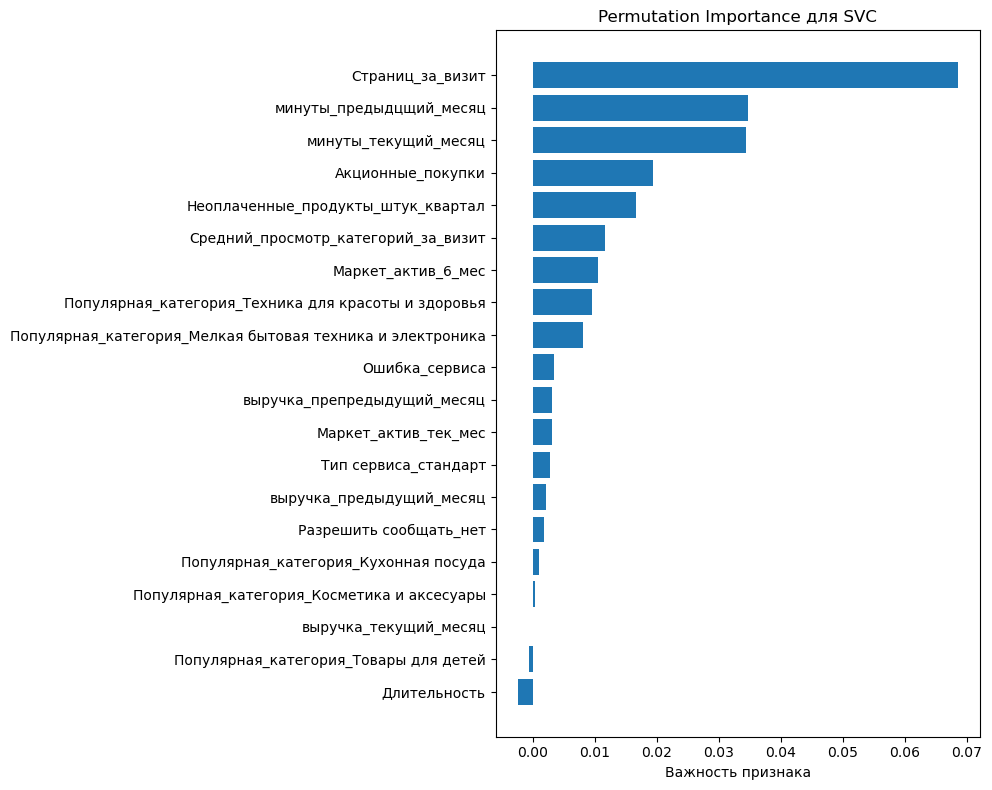

In [447]:
# Визуализация
indices = np.argsort(importances)[::-1]
# Строим горизонтальную столбчатую диаграмму
plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), np.array(feature_names)[indices])
plt.xlabel('Важность признака')
plt.title('Permutation Importance для SVC')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Итоги

- Исходя из анализа важности признаков, можно сказать что для можели наиболее важным является признаки связанные с временем посещения: к-во посещщенных страниц за визит, время в текущем и предыдущем месяце, а также к-во купленных акционных товаров
- При этом длительность, выручка в текущем и предыдущем месяце, а так же 3 из 5-ти популярных категории не важны для можели
- В первую очередь нужно обращать внимание на то, сколько времени тратит пользователь на сайте, а также как много неоплаченных товаров было в его корзине за последние три месяца

## Сегментация покупателей

In [451]:
# Отберем вероятности по снижению покупательской активности
y_pred_proba = clf.predict_proba(X_test_scalled)[:,1]

In [503]:
df_for_segment = X_test.reset_index()
df_for_segment['Веростяность снижения покупательской активности'] = y_pred_proba
df_for_segment = pd.merge(df_for_segment,money,how = 'inner',left_index=True, right_index=True)

In [505]:
df_for_segment.head()

,id_x,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдцщий_месяц,минуты_текущий_месяц,Веростяность снижения покупательской активности,id_y,Прибыль
0,216446,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,4712.0,5160.0,5230.7,15,20,0.344039,215348,0.98
1,215469,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12,8,0.869559,215349,4.16
2,216301,премиум,да,3.9,5,410,0.20,Косметика и аксесуары,3,1,5,14,5052.5,5348.0,4926.4,17,13,0.069851,215350,3.13
3,215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14,0.817899,215351,4.87
4,215500,стандарт,да,3.5,4,573,0.40,Косметика и аксесуары,2,4,1,4,4137.0,4278.0,3808.1,11,12,0.957024,215352,4.21


In [507]:
df_for_segment['Прибыль'].mean()

3.9996615384615386

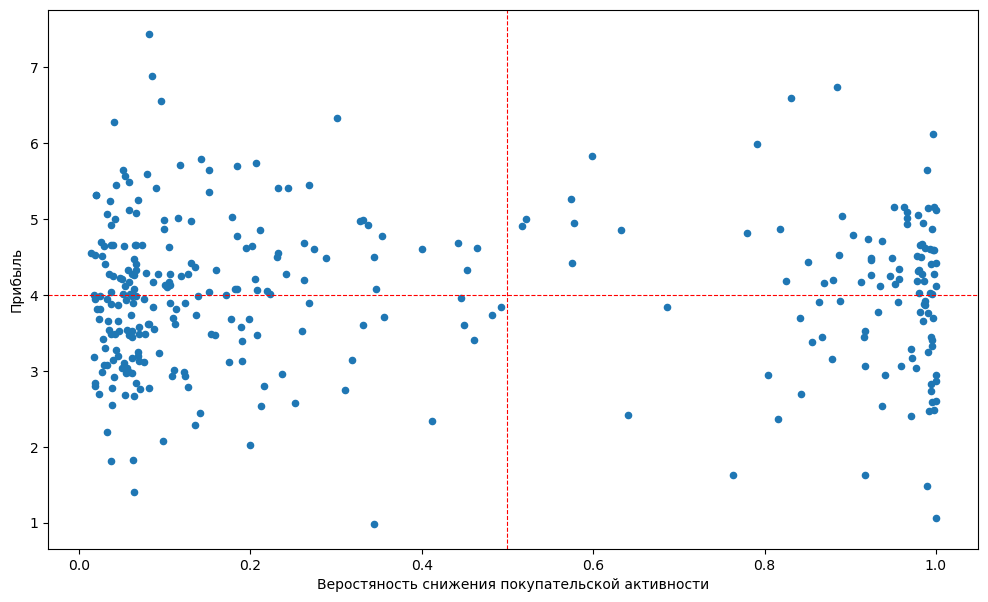

In [509]:
ax = df_for_segment.plot(x='Веростяность снижения покупательской активности', 
                        y='Прибыль', 
                        kind='scatter',
                        figsize = (12,7))
# красная разграничительная линия по оси Х, равняется вероятности 0,5
x_value = 0.5
ax.axvline(x=x_value, color='red', linestyle='--', linewidth=0.8)

# красная разграничительная линия по оси Y, равняется среднему значению прибыли
y_value = df_for_segment['Прибыль'].mean()  # замените на нужное значение
ax.axhline(y=y_value, color='red', linestyle='--', linewidth=0.8)

На графике есть 4 зоны:

1. Верхний левый угол - низкая вероятность к снижению активности, и высокая прибыли. Это "киты". Будут покупать стабильно
2. Нижний левый угол - низкая вероятность к снижению активности, но и прибыль низкая. Это пользователи которые совершаю покупки, но с них мало прибыли. Однако, по прогнозам они и продолжат покупать
3. Нижний правый угол - низкая прибыль и большая вероятность к снижению активности. Эти пользователи не интересны, так как с них мало прибыли и их уход, ни на что не повлияет
4. Верхний правый угол - искомый сегмент. Пользователи, с высокой прибылью, но которые могут снизить свою активность. Их и нужно смотреть

In [553]:
potencial_losses = df_for_segment[(df_for_segment['Прибыль']>=df_for_segment['Прибыль'].mean())&
                                  (df_for_segment['Веростяность снижения покупательской активности']>=0.5)]

In [555]:
potencial_losses.head()

,id_x,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдцщий_месяц,минуты_текущий_месяц,Веростяность снижения покупательской активности,id_y,Прибыль
1,215469,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12,8,0.869559,215349,4.16
3,215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14,0.817899,215351,4.87
4,215500,стандарт,да,3.5,4,573,0.40,Косметика и аксесуары,2,4,1,4,4137.0,4278.0,3808.1,11,12,0.957024,215352,4.21
7,216356,стандарт,да,5.5,4,1022,0.91,Мелкая бытовая техника и электроника,3,0,3,11,5542.5,5082.0,6071.6,13,6,0.573720,215355,5.26
8,215356,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,0.966644,215356,4.93


In [557]:
# добавление столбца общей дельты из месяца в месяц по выручке
potencial_losses['diff_1'] = potencial_losses['выручка_текущий_месяц']-potencial_losses['выручка_предыдущий_месяц']
potencial_losses['diff_2'] = potencial_losses['выручка_предыдущий_месяц']-potencial_losses['выручка_препредыдущий_месяц']

# Добавление общей суммы по выручке
potencial_losses['full_revenue'] = potencial_losses['выручка_текущий_месяц'] +\
                                   potencial_losses['выручка_предыдущий_месяц'] +\
                                   potencial_losses['выручка_препредыдущий_месяц']

/var/folders/hx/5czfjcgx7tg1rzwg_hmdg6v00000gq/T/ipykernel_33598/2864324438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potencial_losses['diff_1'] = potencial_losses['выручка_текущий_месяц']-potencial_losses['выручка_предыдущий_месяц']
/var/folders/hx/5czfjcgx7tg1rzwg_hmdg6v00000gq/T/ipykernel_33598/2864324438.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potencial_losses['diff_2'] = potencial_losses['выручка_предыдущий_месяц']-potencial_losses['выручка_препредыдущий_месяц']
/var/folders/hx/5c

In [565]:
potencial_losses

,id_x,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдцщий_месяц,минуты_текущий_месяц,Веростяность снижения покупательской активности,id_y,Прибыль,diff_1,diff_2,full_revenue
1,215469,премиум,да,4.1,3,813,0.22,Домашний текстиль,3,3,4,5,5403.5,4889.0,5228.0,12,8,0.869559,215349,4.16,-175.5,514.5,15520.5
3,215713,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14,0.817899,215351,4.87,400.4,-51.0,14914.4
4,215500,стандарт,да,3.5,4,573,0.40,Косметика и аксесуары,2,4,1,4,4137.0,4278.0,3808.1,11,12,0.957024,215352,4.21,-328.9,-141.0,12223.1
7,216356,стандарт,да,5.5,4,1022,0.91,Мелкая бытовая техника и электроника,3,0,3,11,5542.5,5082.0,6071.6,13,6,0.573720,215355,5.26,529.1,460.5,16696.1
8,215356,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,0.966644,215356,4.93,419.9,-286.5,13145.9
13,215642,премиум,да,3.8,4,962,0.30,Косметика и аксесуары,2,2,2,5,4857.0,4419.0,5455.0,7,7,0.993382,215361,4.03,598.0,438.0,14731.0
27,215589,стандарт,да,4.8,5,574,0.27,Косметика и аксесуары,2,0,8,5,5372.0,4871.0,6363.9,8,4,0.825352,215375,4.18,991.9,501.0,16606.9
28,215362,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4,4314.0,4765.0,4447.9,13,13,0.924127,215376,4.26,133.9,-451.0,13526.9
37,216595,стандарт,да,4.2,4,753,0.94,Косметика и аксесуары,6,2,3,10,4766.5,4522.0,5108.4,9,17,0.632174,215385,4.85,341.9,244.5,14396.9
40,215719,премиум,да,2.4,5,460,0.22,Косметика и аксесуары,1,6,8,4,5361.0,4260.0,6111.1,10,11,0.962413,215388,5.16,750.1,1101.0,15732.1


Text(0.5, 0, 'Разница')

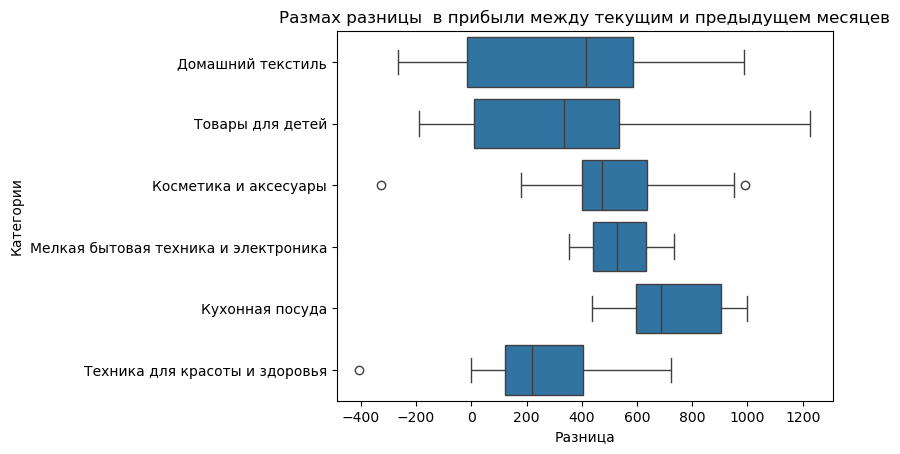

In [583]:
ax = sns.boxplot(x='diff_1', 
                 y='Популярная_категория', 
                 data=potencial_losses, 
                 orient='h')
ax.set_title('Размах разницы  в прибыли между текущим и предыдущем месяцев')
ax.set_ylabel('Категории')
ax.set_xlabel('Разница')

Text(0.5, 0, 'Разница')

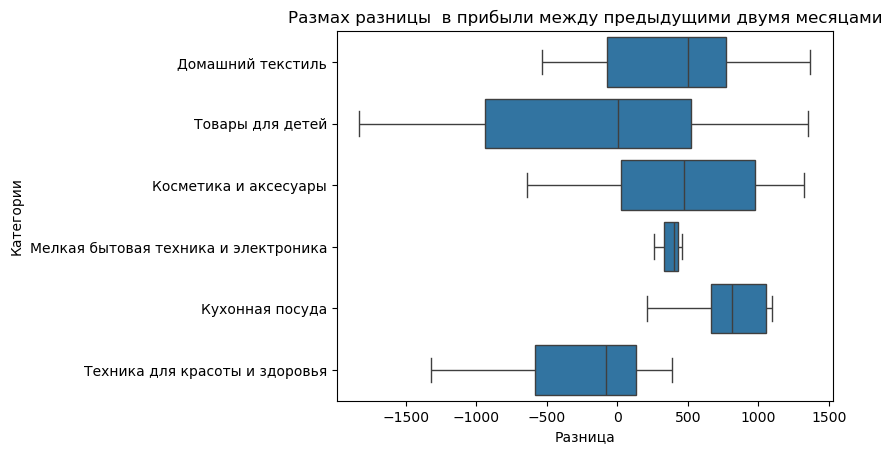

In [585]:
ax = sns.boxplot(x='diff_2', 
                 y='Популярная_категория', 
                 data=potencial_losses, 
                 orient='h')
ax.set_title('Размах разницы  в прибыли между предыдущими двумя месяцами')
ax.set_ylabel('Категории')
ax.set_xlabel('Разница')

Text(0.5, 0, 'Разница')

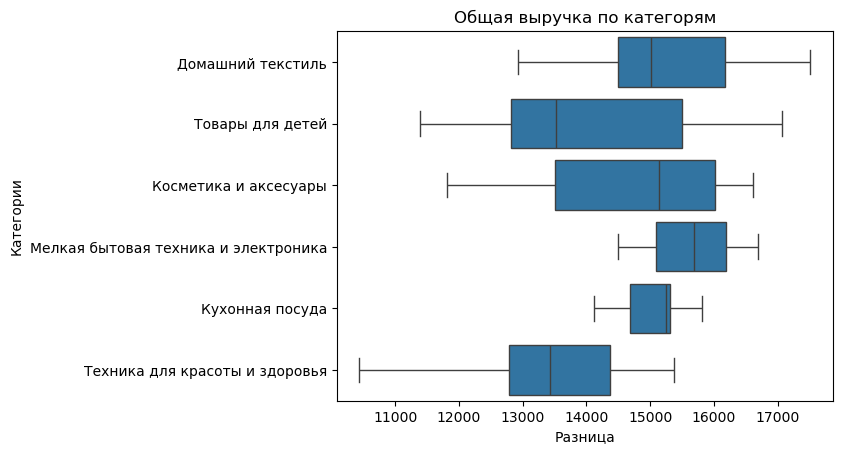

In [589]:
ax = sns.boxplot(x='full_revenue', 
                 y='Популярная_категория', 
                 data=potencial_losses, 
                 orient='h')
ax.set_title('Общая выручка по категорям')
ax.set_ylabel('Категории')
ax.set_xlabel('Разница')

In [593]:
potencial_losses['Популярная_категория'].value_counts(normalize=True)

Популярная_категория
Домашний текстиль                       0.281250
Товары для детей                        0.281250
Косметика и аксесуары                   0.187500
Техника для красоты и здоровья          0.125000
Кухонная посуда                         0.078125
Мелкая бытовая техника и электроника    0.046875
Name: proportion, dtype: float64

### Итоги

1. Основная массиа пользователей, котоыре по прогнозам снизят покупательскую активность приходят в магазин за Домашним тектилем и товарами для детей
2. Исходя из содержимого категория, можно предположить, что это пользователи, у которых в семье появился ребенок - их фокус внимания переключился, по этому они реже пользуются данным магазином.
3. Для поддержания покупательской активности можно предлагать таким пользователям повышенные скидки и акции на товары связанные с детьми 

## Общий вывод

1. Проделана работа по прогнозированию и выявлению признаков пользователей, покупательская активность которых будет снижена
2. В исходных данных были найдены и устранены недочеты по качеству: скорректированны значения в поле "Тип сервисане" и приведены к коректным значениям файл money
3. Для поиска лучшей модели был создан пайплайн, результат которого - модель опорных векторов, которая лучше всего справилась с задачей по определению покупательской активности
4. В ходе анализа признаков было выявлено, что пользователи, чья покупательская активност, по прогнозам, снизится, вероятнее всего будущие или уже ставшие родители, так как основная масса их покупок связана с категориями, связанными с детьми, по этому предлагается, для улучшения их покупательской способности, предлагать таким пользователям акции и скидки по детским и сопутствующим товарам